In [1]:
from google.colab import drive;
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns

In [3]:
df = pd.read_csv('/content/drive/MyDrive/bookings_03_11.csv', low_memory=False).drop(columns='Unnamed: 0')
df['date_book'] = pd.to_datetime(df['date_book']); df

,id_object,date_book,room_type_agg,rooms,amount,prepay,guests,nights,price_per_night,target,...,Td_mean,Td_min,Td_max,Td_sd,click_search,click_ad,direct_visit,click_socnet,click_link,total_traffic
0,1,2019-01-01,Апартаменты,1.0,26600.000000,0.000000,1.000000,2.000000,13300.000000,1,...,-3.6500,-8.3,1.1,2.839517,4778,0,1017,81,294,6501
1,1,2019-01-01,Коттедж,1.0,59400.000000,59400.000000,1.000000,1.000000,59400.000000,1,...,-3.6500,-8.3,1.1,2.839517,4778,0,1017,81,294,6501
2,1,2019-01-01,Стандарт,1.5,13000.000000,7300.000000,2.000000,1.000000,10150.000000,2,...,-3.6500,-8.3,1.1,2.839517,4778,0,1017,81,294,6501
3,1,2019-01-02,Коттедж,1.0,47900.000000,47900.000000,1.000000,2.000000,23950.000000,1,...,-1.3625,-4.5,-0.1,1.678381,6407,0,1412,146,466,9018
4,1,2019-01-02,Стандарт,1.0,14683.181818,13201.363636,1.818182,1.454545,9277.575455,11,...,-1.3625,-4.5,-0.1,1.678381,6407,0,1412,146,466,9018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19710,6,2024-10-28,Студия,1.0,21375.000000,21375.000000,1.000000,1.500000,14012.500000,2,...,-3.6500,-6.3,-1.8,1.683534,1100,532,439,21,163,2455
19711,6,2024-10-29,Стандарт,1.0,8975.000000,4575.250000,1.500000,1.000000,8975.000000,4,...,-4.2500,-5.5,-3.2,0.814160,1040,805,390,26,160,2577
19712,6,2024-10-29,Студия,1.0,22525.000000,17358.333333,1.666667,2.000000,11775.000000,3,...,-4.2500,-5.5,-3.2,0.814160,1040,805,390,26,160,2577
19713,6,2024-10-30,Стандарт,1.0,25445.000000,9393.727273,1.363636,1.636364,13948.181818,11,...,-3.4125,-5.1,-1.8,1.085538,925,853,366,34,158,2466


In [4]:
df_catboost_room = df.copy()
df_catboost_room['Lag_1'] = df_catboost_room.groupby(['id_object', 'room_type_agg'])['target'].shift(1)
df_catboost_room['Lag_7'] = df_catboost_room.groupby(['id_object', 'room_type_agg'])['target'].shift(7)
df_catboost_room['Lag_30'] = df_catboost_room.groupby(['id_object', 'room_type_agg'])['target'].shift(30)
df_catboost_room['Lag_365'] = df_catboost_room.groupby(['id_object', 'room_type_agg'])['target'].shift(365)
df_catboost_room.set_index('date_book', inplace=True)
df_catboost_room

,id_object,room_type_agg,rooms,amount,prepay,guests,nights,price_per_night,target,working_day,...,click_search,click_ad,direct_visit,click_socnet,click_link,total_traffic,Lag_1,Lag_7,Lag_30,Lag_365
date_book,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,Апартаменты,1.0,26600.000000,0.000000,1.000000,2.000000,13300.000000,1,0,...,4778,0,1017,81,294,6501,NaN,NaN,NaN,NaN
2019-01-01,1,Коттедж,1.0,59400.000000,59400.000000,1.000000,1.000000,59400.000000,1,0,...,4778,0,1017,81,294,6501,NaN,NaN,NaN,NaN
2019-01-01,1,Стандарт,1.5,13000.000000,7300.000000,2.000000,1.000000,10150.000000,2,0,...,4778,0,1017,81,294,6501,NaN,NaN,NaN,NaN
2019-01-02,1,Коттедж,1.0,47900.000000,47900.000000,1.000000,2.000000,23950.000000,1,0,...,6407,0,1412,146,466,9018,1.0,NaN,NaN,NaN
2019-01-02,1,Стандарт,1.0,14683.181818,13201.363636,1.818182,1.454545,9277.575455,11,0,...,6407,0,1412,146,466,9018,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,6,Студия,1.0,21375.000000,21375.000000,1.000000,1.500000,14012.500000,2,1,...,1100,532,439,21,163,2455,2.0,4.0,5.0,6.0
2024-10-29,6,Стандарт,1.0,8975.000000,4575.250000,1.500000,1.000000,8975.000000,4,1,...,1040,805,390,26,160,2577,4.0,5.0,9.0,7.0
2024-10-29,6,Студия,1.0,22525.000000,17358.333333,1.666667,2.000000,11775.000000,3,1,...,1040,805,390,26,160,2577,2.0,7.0,2.0,4.0


In [5]:
!pip install catboost

In [7]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(0)

df_catboost_room['id_object'] = df_catboost_room['id_object'].astype('category')
df_catboost_room['room_type_agg'] = df_catboost_room['room_type_agg'].astype('category')

X = df_catboost_room.drop('target', axis=1)
y = df_catboost_room['target']

test_start_date = '2024-07-29'

X_train = X[X.index < test_start_date]
y_train = y[y.index < test_start_date]
X_test = X[X.index >= test_start_date]
y_test = y[y.index >= test_start_date]

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, cat_features=['id_object', 'room_type_agg'], verbose=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# print(f'Mean Absolute Error: {mae:.2f}')

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results['id_object'] = X_test['id_object'].values
results['room_type_agg'] = X_test['room_type_agg'].values
print(results)

0:	learn: 5.5582318	total: 69.5ms	remaining: 1m 9s
100:	learn: 2.8587874	total: 5.39s	remaining: 48s
200:	learn: 2.5259274	total: 8.35s	remaining: 33.2s
300:	learn: 2.3201140	total: 11.1s	remaining: 25.9s
400:	learn: 2.1641646	total: 14.7s	remaining: 22s
500:	learn: 2.0450860	total: 16.9s	remaining: 16.8s
600:	learn: 1.9423843	total: 19s	remaining: 12.6s
700:	learn: 1.8502543	total: 21.2s	remaining: 9.04s
800:	learn: 1.7643444	total: 23.4s	remaining: 5.81s
900:	learn: 1.6919766	total: 27.4s	remaining: 3.01s
999:	learn: 1.6254973	total: 29.7s	remaining: 0us
            Actual  Predicted id_object room_type_agg
date_book                                            
2024-07-29       6   4.774215         1   Апартаменты
2024-07-29       5   4.493194         1       Коттедж
2024-07-29      17  12.522194         1      Стандарт
2024-07-30       9   6.087250         1   Апартаменты
2024-07-30       1   2.633877         1       Коттедж
...            ...        ...       ...           ...
2024-

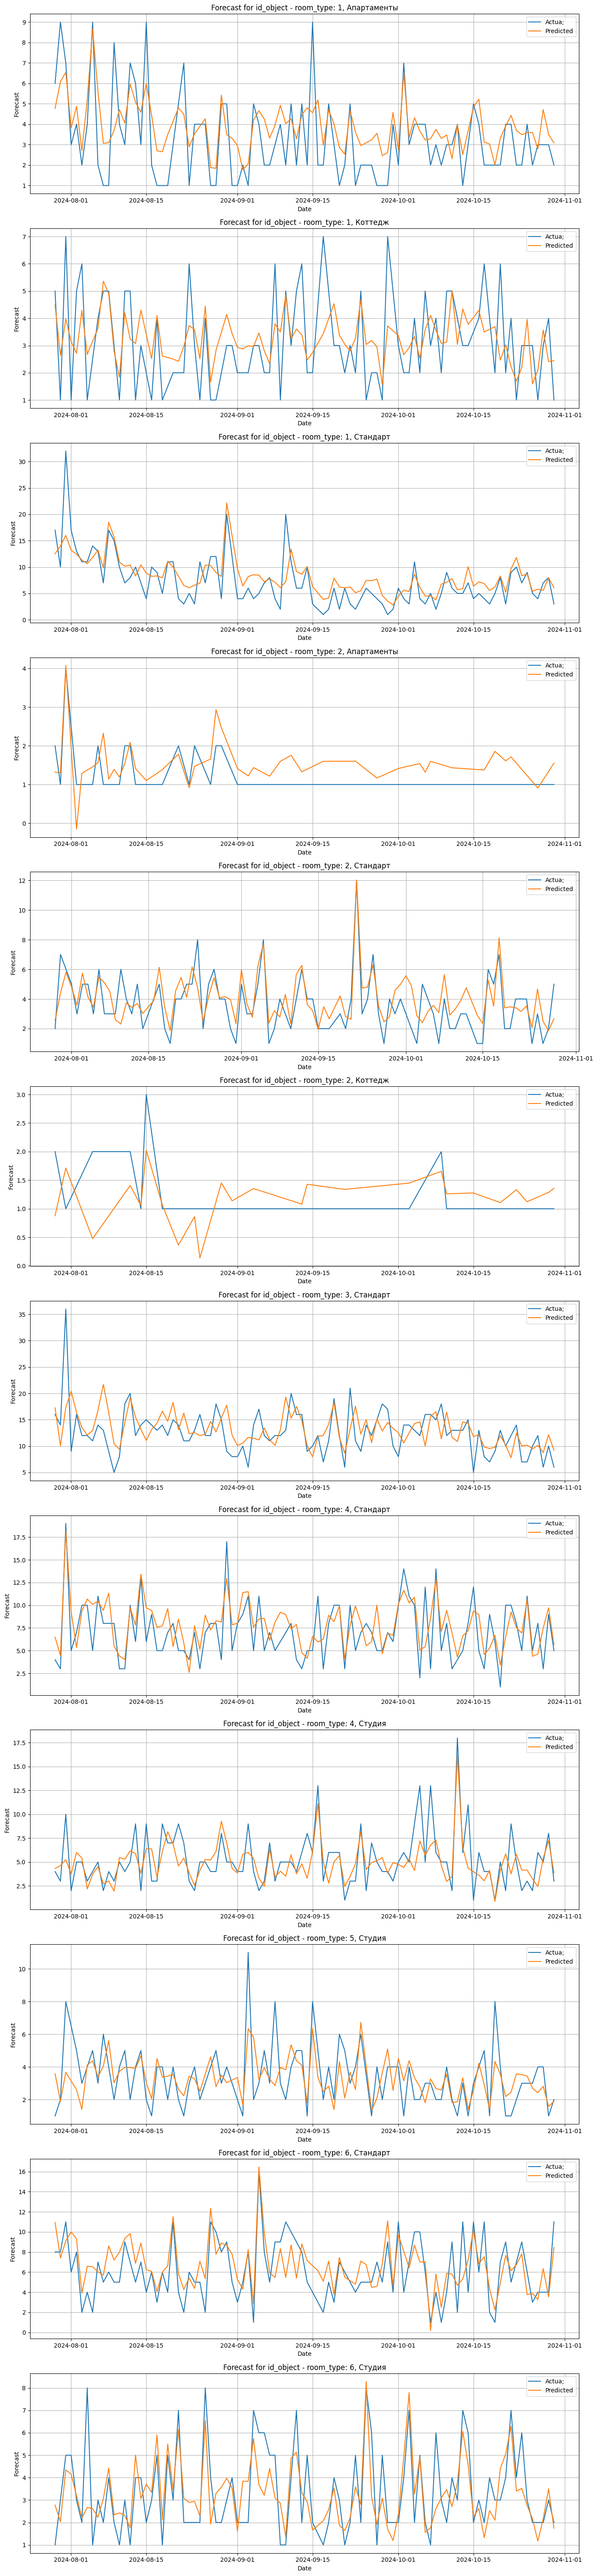

In [12]:
unique_id_objects = df_catboost_room[['id_object', 'room_type_agg']].drop_duplicates()
num_id_objects = len(unique_id_objects)

fig, axes = plt.subplots(num_id_objects, 1, figsize=(14, 5 * num_id_objects))

for ax, (index, row) in zip(axes, unique_id_objects.iterrows()):
    id_object = row['id_object']
    room_type_agg = row['room_type_agg']

    group_test = df_catboost_room[(df_catboost_room.index >= '2024-07-29') & (df_catboost_room['id_object'] == id_object) & (df_catboost_room['room_type_agg'] == room_type_agg)]
    ax.plot(group_test.index, group_test['target'], label='Actua;')

    # group_train = df_catboost_room[(df_catboost_room.index < '2024-07-29') & (df_catboost_room['id_object'] == id_object) & (df_catboost_room['room_type_agg'] == room_type_agg)]
    # ax.plot(group_train.index, group_train['target'], label='Истинные значения - трейн', color = 'green')

    group_forecast = results[(results['id_object'] == id_object) & (results['room_type_agg'] == room_type_agg)]
    ax.plot(group_forecast.index, group_forecast['Predicted'], label='Predicted')

    ax.set_title(f'Forecast for id_object - room_type: {id_object}, {room_type_agg}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Forecast')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


In [ ]:
for index, row in results[['id_object', 'room_type_agg']].drop_duplicates().iterrows():
  id_object = row['id_object']
  room_type_agg = row['room_type_agg']
  y_true = results[(results['id_object'] == id_object) & (results['room_type_agg'] == room_type_agg)]['Actual'].values
  y_pred = results[(results['id_object'] == id_object) & (results['room_type_agg'] == room_type_agg)]['Predicted'].values

  rmse = mean_squared_error(y_true, y_pred)** 0.5
  print(str(id_object) + "--- " + str(room_type_agg) + " ------ " + str(rmse))

1--- Апартаменты ------ 2.56184719301243
1--- Коттедж ------ 1.9316689415438744
1--- Стандарт ------ 5.47610757193131
2--- Апартаменты ------ 0.9853077769329617
2--- Коттедж ------ 0.7752601923148763
2--- Стандарт ------ 3.121484545991834
3--- Стандарт ------ 5.968131927457542
4--- Стандарт ------ 4.355764076399425
4--- Студия ------ 3.0736189042398885
5--- Студия ------ 2.228788022840261
6--- Стандарт ------ 3.336777167654442
6--- Студия ------ 1.963599002818598


In [ ]:
for index, row in results[['id_object', 'room_type_agg']].drop_duplicates().iterrows():
  id_object = row['id_object']
  room_type_agg = row['room_type_agg']
  y_true = results[(results['id_object'] == id_object) & (results['room_type_agg'] == room_type_agg)]['Actual'].values
  y_pred = results[(results['id_object'] == id_object) & (results['room_type_agg'] == room_type_agg)]['Predicted'].values

  mape = np.mean(np.abs((y_true - y_pred) / y_true))
  print(str(id_object) + "--- " + str(room_type_agg) + " ------ " + str(mape))

1--- Апартаменты ------ 1.199401480170366
1--- Коттедж ------ 0.8523878889923105
1--- Стандарт ------ 1.1477554539065544
2--- Апартаменты ------ 0.7527794303617729
2--- Коттедж ------ 0.5570439150088744
2--- Стандарт ------ 1.2596933758553248
3--- Стандарт ------ 0.4880678518336903
4--- Стандарт ------ 0.8110733279499354
4--- Студия ------ 0.6635818701214294
5--- Студия ------ 0.9021798667559142
6--- Стандарт ------ 0.8055756476811144
6--- Студия ------ 0.7441089738680455
